# Emotion recognition with MobileNet

In this portion of the assignment, I will leverage a pre-trained model (based on either the MobileNet or EfficientNet-B0) for the task of emotion recognition.

**[Give an overview about the advantages and differences of the model]**

## Import the libraries and dataset

In [1]:
from datasets import load_dataset               # Function to load a dataset from the HuggingFace database
import matplotlib.pyplot as plt
import numpy as np                              #
from numpy import round, sqrt 
from numpy import random                        # For showing a random array of images from the dataset
from PIL import Image

import tensorflow as tf
import keras
from keras import layers
from keras.applications import mobilenet, MobileNet

dataset_raw = load_dataset("FastJobs/Visual_Emotional_Analysis")
num_data = dataset_raw['train'].shape[0]

# Number of unique labels
num_classes = len(set(dataset_raw['train']['label']))
# Dimension of the input images (taken a single image)
image_dim = np.array(dataset_raw['train']['image'][0]).shape

# Dictionary to decode the meaning of the numerical labels
label_dict = {
    0: 'anger',
    1: 'contempt',
    2: 'disgust',
    3: 'fear',
    4: 'happy',
    5: 'neural',
    6: 'sad',
    7: 'suprise'
}

Resolving data files:   0%|          | 0/800 [00:00<?, ?it/s]

Make a train-test split to separate the training+validation data from the holdout set

In [2]:
dataset_split = dataset_raw['train'].train_test_split(test_size=0.2)

print(dataset_split)

num_train = len(dataset_split['train']['image'])
# num_train = dataset_split['train'].shape[0]
num_test = len(dataset_split['test']['image'])
# num_test = dataset_split['test'].shape[0]

# Print the number of samples in each set
print(f"There are {num_train} samples in the training set \n"
      f"There are {num_test} samples in the testing set")



DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 640
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 160
    })
})
There are 640 samples in the training set 
There are 160 samples in the testing set


## Data discovery
Display some examples from the training dataset

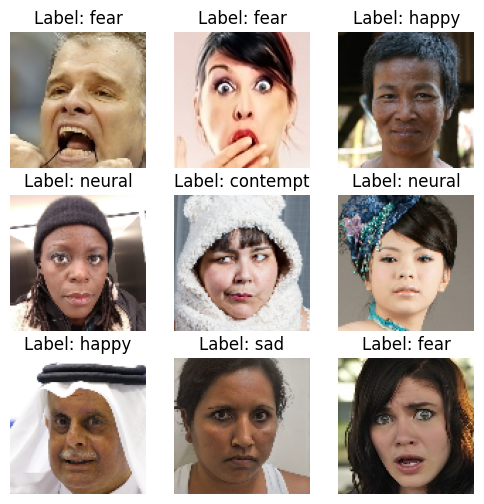

In [3]:
num_samples = 9                                                                             # number of samples to be display
num_rows = np.int8(round(sqrt(num_samples))); num_cols = np.int8(num_samples/num_rows)      # number of rows and columns for the subplot
rand = random.randint(num_train,size = (num_samples))                                       # random index for choosing the samples in the dataset

# Sample random images and their indices
image_rand = dataset_split['train'][rand]['image']
label_rand = dataset_split['train'][rand]['label']

fig, axes = plt.subplots(num_rows,num_cols,figsize=(num_rows*2,num_cols*2))

for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        image = image_rand[index]  # Extract the image
        label = label_rand[index]  # Extract the label

        ax = axes[i,j]
        # Display the image
        ax.imshow(image)
        ax.set_title(f"Label: {label_dict[label]}")
        ax.axis("off")

To investigate the dimension of an image in this dataset, the image first need to be converted to a numpy array. The code block below shows that dimension of each image in terms of width x height x depth

In [4]:
# Let's take a random image from the sample
image = image_rand[random.randint(num_samples)]

# Dimension of the PIL image
print(f"The 2D size of the image is {image.size}\n"
      f"The depth of the image can be inferred from the image mode: {image.mode}\n")

# Dimension of the image_array
image_array = np.array(image)
image_dim = image_array.shape
print(f"Once converted to a numpy array, we can explicitly see the 3D size as \n{image_dim}")


The 2D size of the image is (96, 96)
The depth of the image can be inferred from the image mode: RGB

Once converted to a numpy array, we can explicitly see the 3D size as 
(96, 96, 3)


## Data Unpacking

In [5]:
image_train_array = np.array(dataset_split['train']['image'])
label_train_array = np.array(dataset_split['train']['label'])

image_test_array = np.array(dataset_split['test']['image'])
label_test_array = np.array(dataset_split['test']['label'])

## Image data augmentation layer

Given that the model only has about 800 instances, I will perform data augmentation by applying some random transformation to the data. The goal of this layer is to present the pre-trained model with different transformation of each image every time the image is fed through the network. Thus, it does not overfit on certain feature extraction 
This is accomplished by adding some keras sequential layers that apply the transformation to the image before it is fed into the neural network.

The code block belows show the construction of an image augmentation layer that will be added as the first layer of a pre-trained model.

In [6]:
keras.backend.clear_session()

image_augmentation = keras.Sequential([
    layers.Input(shape=(96,96,3)),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.4),
    layers.RandomTranslation(0.1,0.1),
    layers.RandomZoom(0.1,0.1)
])

The data augmentation is visualized in the code block below. I will maintain the number of samples and the sample of images/labels from the start of this notebook for a comparison.

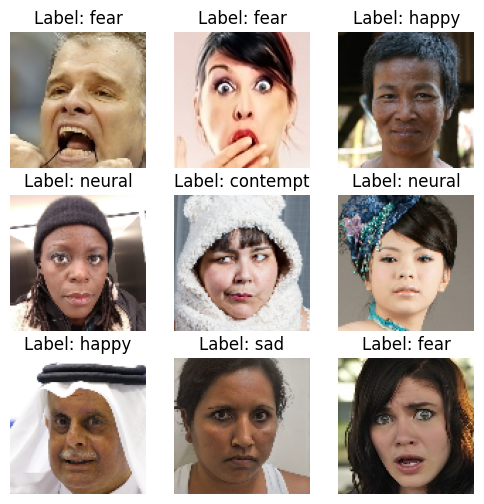

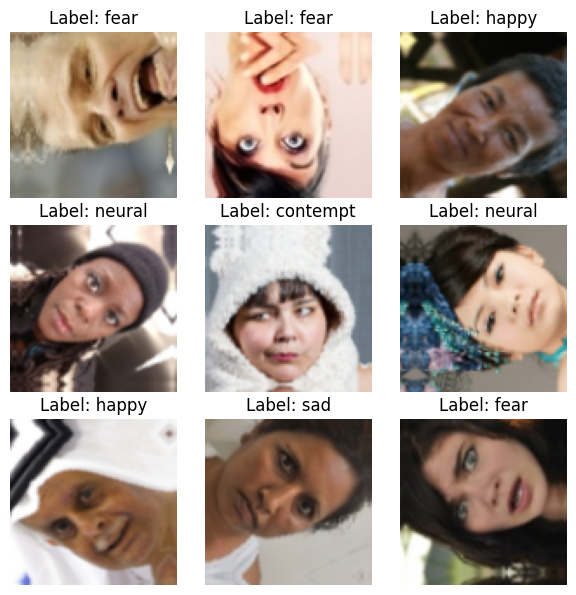

In [7]:
# Sample random images and their indices
image_rand_array = image_train_array[rand]
label_rand_array = label_train_array[rand]

fig, axes1 = plt.subplots(num_rows,num_cols,figsize=(num_rows*2,num_cols*2))
fig, axes2 = plt.subplots(num_rows,num_cols,figsize=(num_rows*2,num_cols*2))

for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        image = image_rand_array[index]  # Extract the image
        label = label_rand_array[index]  # Extract the label
        
        # Original pictures (no augmentation layer applied)
        ax1 = axes1[i,j]
        ax1.axis("off")
        # Display the image
        ax1.imshow(image)
        ax1.set_title(f"Label: {label_dict[label]}")
        

        # Apply the augmentation layer on the image
        augmented_image = image_augmentation(tf.expand_dims(image, axis=0), training=True)/255

        ax2 = axes2[i,j]
        ax2.axis("off")
        # Display the image
        ax2.imshow(tf.squeeze(augmented_image).numpy())
        ax2.set_title(f"Label: {label_dict[label]}")
        

        plt.tight_layout()

## Building the MobileNet-based model

### MobileNet preprocessing

In [8]:
# Define the image augmentation layer
image_set_augmentation = keras.Sequential([
    layers.Input(shape=(96, 96, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomZoom(0.1, 0.1)
])

augmented_images = image_set_augmentation(image_train_array)
print(f"Dimension of the augmented training images: \n{augmented_images.shape}\n")

preprocessed_images = mobilenet.preprocess_input(augmented_images)
print(f"Dimension of the images after preprocessing for MobileNet: \n{preprocessed_images.shape}\n")

# Uncomment the following line to observe that the intensity of the pixels are normalized to [-1,1]
# print(preprocessed_images)

Dimension of the augmented training images: 
(640, 96, 96, 3)

Dimension of the images after preprocessing for MobileNet: 
(640, 96, 96, 3)



### MobileNet Base Model

In [9]:
base_model = MobileNet(input_shape=image_dim, 
                       include_top=False)
base_model.trainable = False
base_model.summary()

C:\Users\caomi\AppData\Local\Temp\ipykernel_44704\3163079816.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(input_shape=image_dim,


Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 48, 48, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 48, 48, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 48, 48, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 48, 48, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 24, 24, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 24, 24, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 24, 24, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 24, 24, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

### Full Model

In [10]:
# Create the model
model = keras.Sequential([
    layers.Input(shape=image_dim),
    image_augmentation,                                 # Augment the training images
    layers.Lambda(mobilenet.preprocess_input),          # mobilenet preprocessing function
    base_model,                                         # MobileNet network
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),                    
    layers.Dropout(0.4),                                # To help with generalization
    layers.Dense(num_classes, activation="softmax")     # Custom classification layer
])

initial_weights = model.get_weights()

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 3, 3, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3, 3, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,241,160 (12.36 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 3,230,912 (12.32 MB)

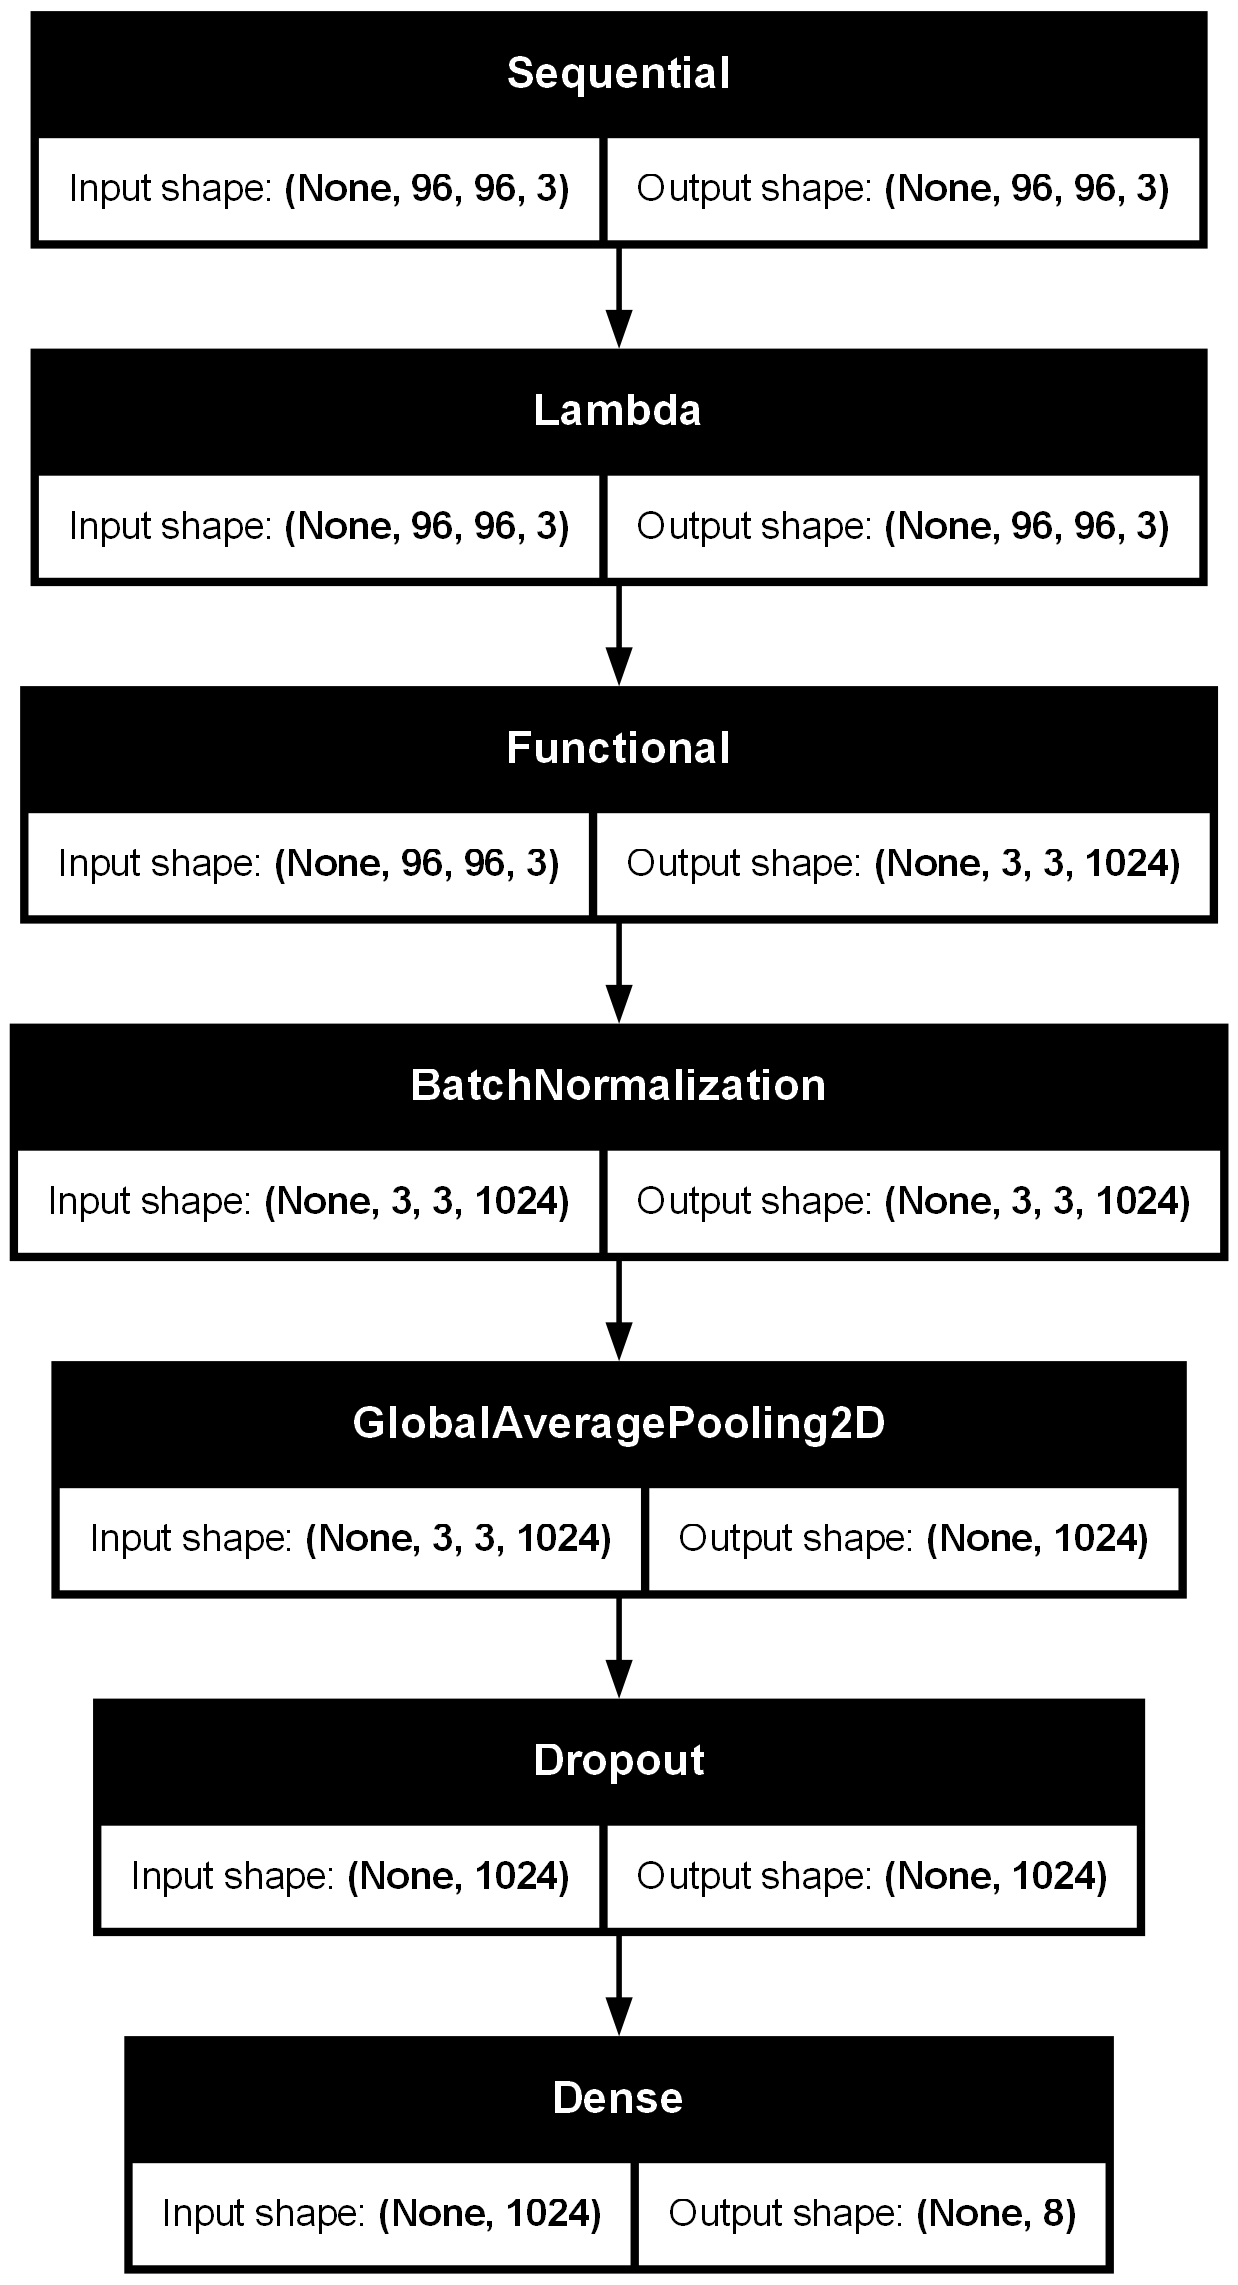

In [11]:
len(model.trainable_variables)
keras.utils.plot_model(model,show_shapes=True)

### Model Training

Before any training, the accuracy of the model is fairly poor and is no better than random chance (1/8=12.5%)

In [12]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005),
              loss=keras.losses.SparseCategoricalCrossentropy,
              metrics=["accuracy"])
loss0, acc0 = model.evaluate(image_train_array,label_train_array)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(acc0))

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.1174 - loss: 4.5053
initial loss: 4.63
initial accuracy: 0.12


In [13]:
# Intitial training with frozen base model
initial_lr = 0.0005
initial_batch_size = 32
initial_epochs = 200



model.set_weights(initial_weights)

# # Learning rate scheduler
# initial_lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=initial_lr,
#     decay_steps=1000,
#     decay_rate=0.5
# )
base_model.trainable = False
model.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_lr),
              loss=keras.losses.SparseCategoricalCrossentropy,
              metrics=["accuracy"])
model.summary()

history_initial = model.fit(image_train_array,
                    label_train_array,
                    epochs=initial_epochs,
                    batch_size=initial_batch_size,
                    validation_split=0.2,
                    verbose=2)

# Fine tuning by unfreezing some later layers of MobileNet
ftune_lr = 0.00005
ftune_batch_size = 16
ftune_epochs = 100
unfrozen_layer = -10

base_model.trainable = True

for layer in base_model.layers[:unfrozen_layer]:
    layer.trainable = False

# Learning rate scheduler
ftune_lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=ftune_lr,
    decay_steps=1000,
    decay_rate=0.5
)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=ftune_lr_scheduler),
              loss=keras.losses.SparseCategoricalCrossentropy,
              metrics=["accuracy"])
model.summary()

history_fine = model.fit(image_train_array, 
                         label_train_array, 
                         epochs=initial_epochs + ftune_epochs,
                         validation_split=0.2,
                         initial_epoch=history_initial.epoch[-1],       # Resume from previous training
                         verbose = 2)  

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 3, 3, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3, 3, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,241,160 (12.36 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 3,230,912 (12.32 MB)

Epoch 1/200
16/16 - 3s - 187ms/step - accuracy: 0.1211 - loss: 2.7069 - val_accuracy: 0.0938 - val_loss: 3.7358
Epoch 2/200
16/16 - 1s - 49ms/step - accuracy: 0.1504 - loss: 2.6170 - val_accuracy: 0.0859 - val_loss: 3.1438
Epoch 3/200
16/16 - 1s - 50ms/step - accuracy: 0.1758 - loss: 2.4230 - val_accuracy: 0.1250 - val_loss: 2.8460
Epoch 4/200
16/16 - 1s - 50ms/step - accuracy: 0.2344 - loss: 2.2968 - val_accuracy: 0.1250 - val_loss: 2.6429
Epoch 5/200
16/16 - 1s - 49ms/step - accuracy: 0.2031 - loss: 2.2202 - val_accuracy: 0.1406 - val_loss: 2.5354
Epoch 6/200
16/16 - 1s - 56ms/step - accuracy: 0.2363 - loss: 2.1302 - val_accuracy: 0.1641 - val_loss: 2.4253
Epoch 7/200
16/16 - 1s - 56ms/step - accuracy: 0.2520 - loss: 2.0680 - val_accuracy: 0.1797 - val_loss: 2.3438
Epoch 8/200
16/16 - 1s - 50ms/step - accuracy: 0.2383 - loss: 2.1001 - val_accuracy: 0.1797 - val_loss: 2.2745
Epoch 9/200
16/16 - 1s - 50ms/step - accuracy: 0.2578 - loss: 2.0535 - val_accuracy: 0.1875 - val_loss: 2.2363


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 3, 3, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3, 3, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,241,160 (12.36 MB)

 Trainable params: 1,598,472 (6.10 MB)

 Non-trainable params: 1,642,688 (6.27 MB)

Epoch 200/300
16/16 - 4s - 225ms/step - accuracy: 0.4668 - loss: 1.4426 - val_accuracy: 0.2500 - val_loss: 2.2293
Epoch 201/300
16/16 - 1s - 59ms/step - accuracy: 0.5078 - loss: 1.3902 - val_accuracy: 0.2578 - val_loss: 2.1483
Epoch 202/300
16/16 - 1s - 61ms/step - accuracy: 0.4668 - loss: 1.4285 - val_accuracy: 0.2344 - val_loss: 2.1536
Epoch 203/300
16/16 - 1s - 62ms/step - accuracy: 0.4609 - loss: 1.4290 - val_accuracy: 0.2500 - val_loss: 2.1310
Epoch 204/300
16/16 - 1s - 61ms/step - accuracy: 0.5098 - loss: 1.3578 - val_accuracy: 0.2578 - val_loss: 2.0734
Epoch 205/300
16/16 - 1s - 60ms/step - accuracy: 0.4824 - loss: 1.3857 - val_accuracy: 0.2656 - val_loss: 2.1124
Epoch 206/300
16/16 - 1s - 63ms/step - accuracy: 0.5352 - loss: 1.2870 - val_accuracy: 0.2656 - val_loss: 2.1593
Epoch 207/300
16/16 - 1s - 65ms/step - accuracy: 0.5391 - loss: 1.2762 - val_accuracy: 0.2656 - val_loss: 2.1205
Epoch 208/300
16/16 - 1s - 64ms/step - accuracy: 0.4941 - loss: 1.3373 - val_accuracy: 0.2734 -

In [14]:
def plot_performance(history, learning_rate=None, batch_size=None, finetune_epochs=None):
  plt.figure(figsize=(10,5))

  

  # Determine whether history is keras history or a dictionary to appropriately extract the history data
  if isinstance(history, keras.src.callbacks.history.History):
    history_data = history.history        # Extract the history dictionary
  else:
    history_data = history                # Assume it's already a dictionary

  # Accuracy of model training and validation vs training epoch
  plt.subplot(1,2,1)
  ylim_acc = [0, max(max(history_data['accuracy']),max(history_data['val_accuracy']))]
  plt.plot(history_data['accuracy'], label = 'Training accuracy')
  plt.plot(history_data['val_accuracy'], label = 'Validation accuracy')
  plt.ylim(ylim_acc)
  if finetune_epochs:
    plt.plot([finetune_epochs-1, finetune_epochs-1],plt.ylim(), label = 'Fine tuning')
  else:
    pass

  if learning_rate and batch_size:
    plt.title(f'Model accuracy \n lr = {learning_rate}, batch size = {batch_size}')
  else: plt.title('Model accuracy')

  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(loc='lower right')

  # Loss during model training and validation
  plt.subplot(1,2,2)
  ylim_loss = [0, max(max(history_data['loss']),max(history_data['val_loss']))]
  # print(len(history_data['loss']))
  plt.plot(history_data['loss'], label = 'Training loss')
  plt.plot(history_data['val_loss'], label = 'Validation loss')
  plt.ylim(ylim_loss)
  if finetune_epochs:
    plt.plot([finetune_epochs-1, finetune_epochs-1],plt.ylim(), label = 'Fine tuning')
  else:
    pass

  if learning_rate and batch_size:
    plt.title(f'Model loss \n lr = {learning_rate}, batch size = {batch_size}')
  else: plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(loc='lower right')
  plt.show()

  print(f"The model has a training accuracy of {history_data['accuracy'][-1]*100:.2f}%\n"
      f"The model has a validation accuracy of {history_data['val_accuracy'][-1]*100:.2f}%")
  return

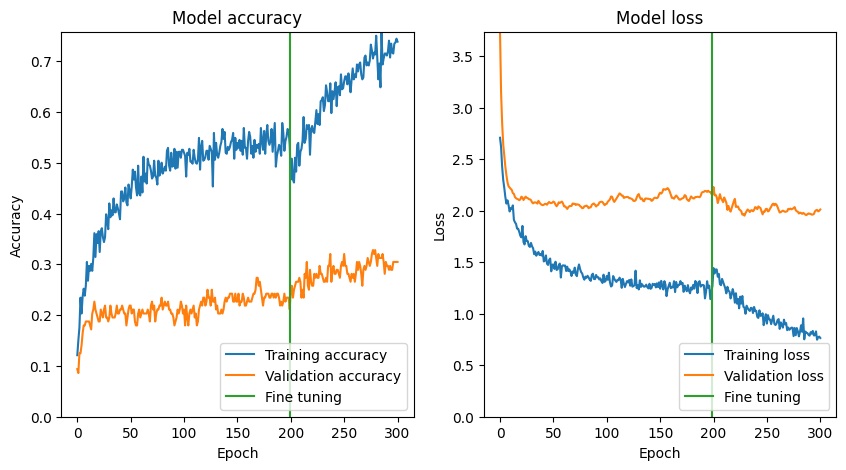

The model has a training accuracy of 73.83%
The model has a validation accuracy of 30.47%


In [15]:
combined_history = {
    'accuracy': history_initial.history['accuracy'] + history_fine.history['accuracy'],
    'val_accuracy': history_initial.history['val_accuracy'] + history_fine.history['val_accuracy'],
    'loss': history_initial.history['loss'] + history_fine.history['loss'],
    'val_loss': history_initial.history['val_loss'] + history_fine.history['val_loss']
}

plot_performance(combined_history,finetune_epochs=initial_epochs)

## Model evaluation and prediction

### Model evaluation

In [16]:
test_loss, test_acc =  model.evaluate(image_test_array,label_test_array)
print(f"Test accuracy: {test_acc}\n"
      f"Test loss: {test_loss}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2983 - loss: 2.1395
Test accuracy: 0.3062500059604645
Test loss: 2.011277437210083


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


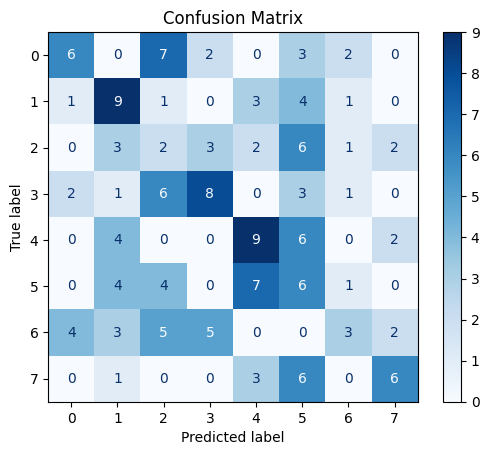

{0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'neural', 6: 'sad', 7: 'suprise'}


In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

prediction_array = np.argmax(model.predict(image_test_array), axis=1)

cm = confusion_matrix(label_test_array, prediction_array)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)  # You can change the color map as desired
plt.title("Confusion Matrix")
plt.show()
print(label_dict)

### Model prediction & visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


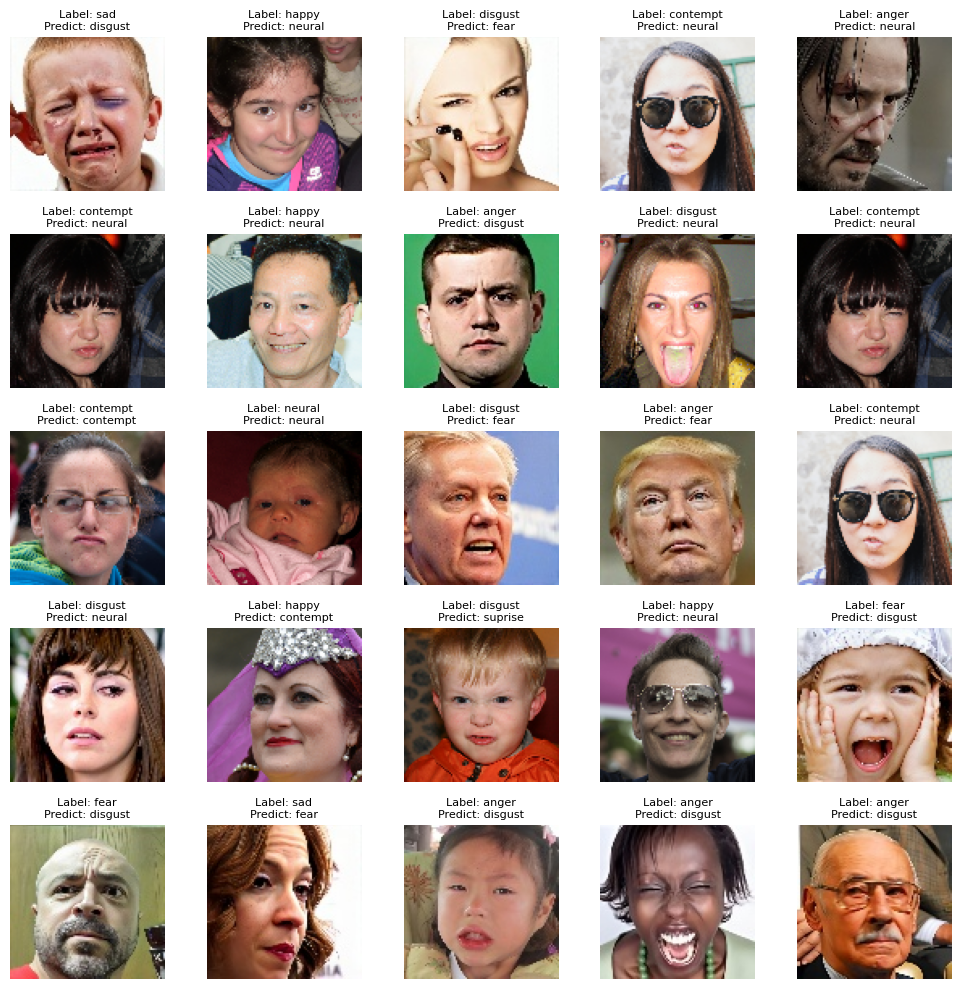

In [18]:
# Sample random images and their indices
num_samples = 25                                                                             # number of samples to be display
num_rows = int(round(sqrt(num_samples))); num_cols = int(num_samples/num_rows)      # number of rows and columns for the subplot
rand = random.randint(num_test,size = (num_samples))                                       # random index for choosing the samples in the dataset

image_test_rand_array = image_test_array[rand]
label_test_rand_array = label_test_array[rand]
prediction_rand_array = np.argmax(model.predict(image_test_rand_array),axis=1)

plt.figure(figsize=(num_rows*2,num_cols*2))
# fig, axes1 = plt.subplots(num_rows,num_cols,figsize=(num_rows*2,num_cols*2))

for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        plt.subplot(num_rows,num_cols,index+1)
        image = image_test_rand_array[index]  # Extract the image
        label = label_test_rand_array[index]  # Extract the label
        prediction = prediction_rand_array[index]

        # Original pictures (no augmentation layer applied)
        plt.axis("off")
        # Display the image
        plt.imshow(image)
        plt.title(f"Label: {label_dict[label]}\n"
                  f"Predict: {label_dict[prediction]}",
                  fontsize = 8) 

plt.tight_layout()